This notebook tests the python btrack module.

In [1]:
from midap.tracking.model_tracking_bayesian import RunBayesianTracker

import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import regionprops
from scipy.spatial import distance

### Load segmentations

In [2]:
segm_files = np.sort(glob.glob('../example_data/Pos58/TXRED/seg_im/*.png'))
segmentation = np.array([io.imread(i) for i in segm_files])

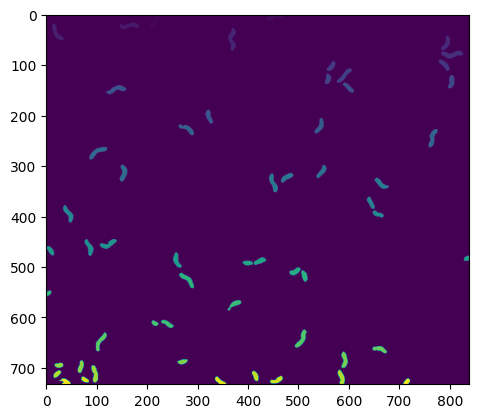

In [3]:
plt.imshow(segmentation[3, ...])

### Run the tracking

In [4]:
tracker_obj = RunBayesianTracker(segmentation)
tracker_obj.run_bayesian_model()
#tracker_obj.tracker.tracks

[INFO][2022/12/01 01:58:33 PM] Localizing objects from segmentation...
[INFO][2022/12/01 01:58:33 PM] Objects are of type: <class 'dict'>
[INFO][2022/12/01 01:58:33 PM] ...Found 572 objects in 10 frames.
[INFO][2022/12/01 01:58:33 PM] Loaded btrack: /Users/franziskaoschmann/miniconda3/envs/midap/lib/python3.8/site-packages/btrack/libs/libtracker.dylib
[INFO][2022/12/01 01:58:33 PM] btrack (v0.4.6) library imported
[INFO][2022/12/01 01:58:33 PM] Starting BayesianTracker session
[INFO][2022/12/01 01:58:33 PM] Loading configuration file: /Users/franziskaoschmann/Library/Caches/btrack-examples/examples/cell_config.json
[INFO][2022/12/01 01:58:33 PM] Setting max_search_radius -> 50
[INFO][2022/12/01 01:58:33 PM] Setting features -> ['area', 'major_axis_length', 'minor_axis_length', 'orientation']
[INFO][2022/12/01 01:58:33 PM] Objects are of type: <class 'list'>
[INFO][2022/12/01 01:58:33 PM] Setting volume -> ((0, 1600), (0, 1200))
[WARNING][2022/12/01 01:58:33 PM] `track_interactive` will

GLPK Integer Optimizer 5.0
316 rows, 253 columns, 352 non-zeros
253 integer variables, all of which are binary
Preprocessing...
158 rows, 253 columns, 352 non-zeros
253 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 158
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
158 rows, 253 columns, 352 non-zeros
*     0: obj =   1.787065070e+02 inf =   0.000e+00 (32)
*    28: obj =   8.679521051e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    28: mip =     not found yet >=              -inf        (1; 0)
+    28: >>>>>   8.679521051e+01 >=   8.679521051e+01   0.0% (1; 0)
+    28: mip =   8.679521051e+01 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


### Inspecting the output

In [5]:
tracker_obj.tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,orientation,major_axis_length,area
0,1,0,214.452381,9.938095,0.0,1,1,5,0,False,9.920362,-0.688565,27.589564,210
1,1,1,215.153543,12.811024,0.0,1,1,5,0,False,10.505262,-0.651998,33.028708,254
2,1,2,216.326693,13.087649,0.0,1,1,5,0,False,10.539768,-0.568083,33.199251,251
3,1,3,214.485075,14.791045,0.0,1,1,5,0,False,10.721822,-0.525138,35.978187,268
4,1,4,214.945255,15.346715,0.0,1,1,5,0,False,10.790982,-0.526228,37.220288,274
5,1,5,211.033445,19.344482,0.0,1,1,5,0,False,10.919908,-0.533861,41.166148,299
6,1,6,210.061920,19.281734,0.0,1,1,5,0,False,11.584634,-0.536127,43.436804,323
7,1,7,210.878963,19.512968,0.0,1,1,5,0,False,12.041522,-0.518836,45.569067,347
8,1,8,210.136490,18.977716,0.0,1,1,5,0,False,11.854883,-0.533065,47.634077,359
9,1,9,204.170000,28.070000,0.0,1,1,5,0,False,10.075760,-0.112001,25.690820,200


### Visualizing the tracking

In [6]:
def find_nearest_neighbour(point, seg):
    centroids = [r.centroid for r in regionprops(seg)]
    labels = [r.label for r in regionprops(seg)]
    ix_min = np.argmin([distance.euclidean(c, point) for c in centroids])
    return seg == labels[ix_min]

In [7]:
label_stack = np.zeros(segmentation.shape)
for tr in tracker_obj.tracks:
    for i in range(len(tr['t'])):
        #print(tr)
        point = (int(tr['y'][i]), int(tr['x'][i]))
        label_stack[i][find_nearest_neighbour(point, segmentation[i])] = tr['ID']

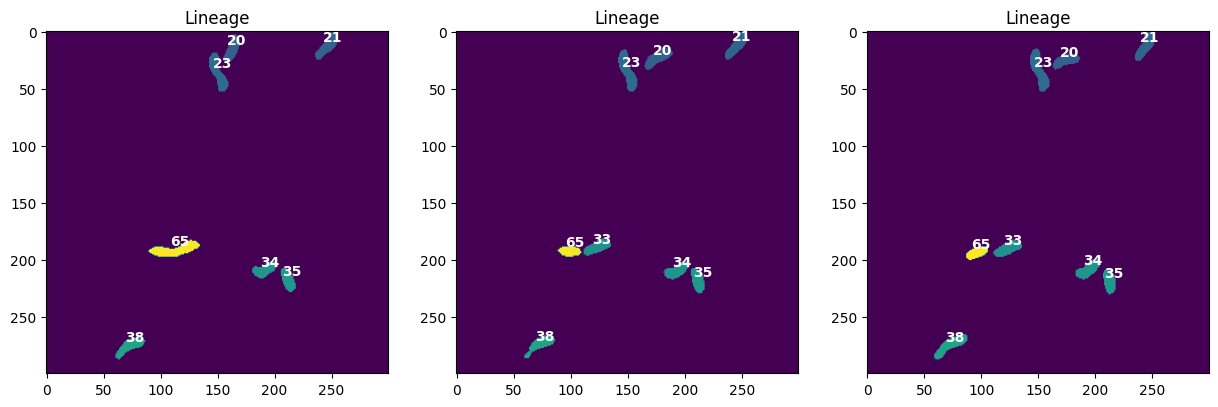

In [8]:
plt.figure(figsize=(15,10))
ax = plt.subplot(1,3,1)
img = label_stack[2][300:600,300:600]
plt.imshow(img)
plt.title('Lineage')
reg = regionprops(img.astype(int))
center = [r.centroid for r in reg]
labels = [r.label for r in reg]
for c, l in zip(center, labels):
    x, y = c
    x=int(np.ceil(x))
    y=int(np.ceil(y))
    ax.text(y-5,x-5, str(l), color='w', weight='bold')

ax = plt.subplot(1,3,2)
img = label_stack[3][300:600,300:600]
plt.imshow(img)
plt.title('Lineage')
reg = regionprops(img.astype(int))
center = [r.centroid for r in reg]
labels = [r.label for r in reg]
for c, l in zip(center, labels):
    x, y = c
    x=int(np.ceil(x))
    y=int(np.ceil(y))
    ax.text(y-5,x-5, str(l), color='w', weight='bold')

ax = plt.subplot(1,3,3)
img = label_stack[4][300:600,300:600]
plt.imshow(img)
plt.title('Lineage')
reg = regionprops(img.astype(int))
center = [r.centroid for r in reg]
labels = [r.label for r in reg]
for c, l in zip(center, labels):
    x, y = c
    x=int(np.ceil(x))
    y=int(np.ceil(y))
    ax.text(y-5,x-5, str(l), color='w', weight='bold')